## 一定要選對conda的env，要不然會出現cublas error
## 如果是使用Docker要先在命令列中安裝Augmentor及cnn_finetune

```
pip install Augmentor --upgrade
pip install cnn_finetune --upgrade
```

In [ ]:
# 小心不要亂昇級，gpu不能用！！

# !pip install --upgrade pip
# !pip install Augmentor --upgrade
# !pip install cnn_finetune --upgrade
# !pip install torch --upgrade
# !pip install torchvision --upgrade

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from cnn_finetune import make_model
from tqdm import tqdm

plt.ion()   # interactive mode

In [2]:
transmean = (0.2936777174472809, 0.2521389126777649, 0.23884029686450958)
transstd = (0.30015286803245544, 0.2760666012763977, 0.2753622233867645)
image_size = (256, 256)
batch_size = 64

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(transmean, transstd)
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(transmean, transstd)
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(transmean, transstd)
    ]),
}


data_dir = './dstest/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

'''
在train的dataset中，我們使用WeightedRandomSampler
來平均取得每一個類別的機率，因此在設定replacement=True
之後，就會平均從每一個類別取得樣本，用在不平衡的資料
集中
'''

target = torch.tensor(image_datasets['train'].targets)
class_sample_count = torch.tensor([(target == t).sum() 
                                   for t in torch.unique(target, sorted=True)])
print(class_sample_count)

# weight = 1. / class_sample_count.float()
# samples_weight = torch.tensor([weight[t] for t in target])
# train_sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=False)

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
#                                               shuffle=True, num_workers=8)
#                for x in ['train', 'val', 'test']}


dataloaders = {}
dataloaders['train'] = DataLoader(image_datasets['train'], batch_size=batch_size,
                                  shuffle=True,
                                  #sampler=train_sampler,
                                  num_workers=8
                                 )

dataloaders['val'] = DataLoader(image_datasets['val'], batch_size=batch_size,
                                shuffle=True,
                                num_workers=8
                               )

dataloaders['test'] = DataLoader(image_datasets['test'], batch_size=batch_size,
                                shuffle=True,
                                num_workers=8
                                )

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor([4167, 4167, 4167, 4167])


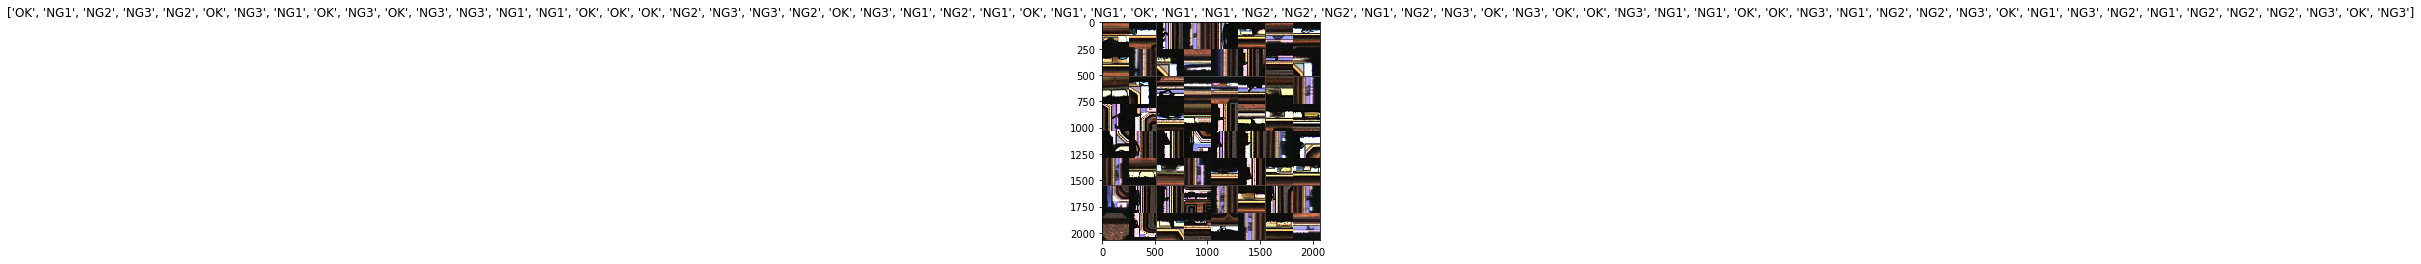

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(transmean)
    std = np.array(transstd)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig = plt.figure(figsize=(20,30))
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
num_classes = 4


'''
vgg16bn

model_ft = models.alexnet(pretrained=True)
model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)
'''

'''
Resnet18


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
'''

'''
ResNext


model_ft = models.resnext101_32x8d(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
'''

'''
Densenet201
'''
model_ft = models.densenet201(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, num_classes)


'''
Xception

model_ft = make_model('xception', num_classes=num_classes, pretrained=True)
'''

# model_ft = make_model("inceptionresnetv2", num_classes=4)


if torch.cuda.device_count() > 1:
    print("On", torch.cuda.device_count(), "GPUs")
    model_ft = nn.DataParallel(model_ft)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

On 2 GPUs


## 計算模型參數數量


In [9]:
total_params = sum(p.numel() for p in model_ft.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

18,100,612 total parameters.
18,100,612 training parameters.


In [10]:
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=25)

  0%|          | 0/261 [00:00<?, ?it/s]

Epoch 0/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.4916 Acc: 0.7858


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3112 Acc: 0.8754

Epoch 1/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.2741 Acc: 0.8889


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.2620 Acc: 0.8951

Epoch 2/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.1892 Acc: 0.9273


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.2319 Acc: 0.9057

Epoch 3/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.1279 Acc: 0.9528


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.2333 Acc: 0.9121

Epoch 4/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0811 Acc: 0.9716


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.2834 Acc: 0.9019

Epoch 5/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0505 Acc: 0.9846


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.2946 Acc: 0.9068

Epoch 6/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.9946


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.2800 Acc: 0.9107

Epoch 7/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0180 Acc: 0.9968


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.2824 Acc: 0.9148

Epoch 8/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0165 Acc: 0.9974


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.2843 Acc: 0.9157

Epoch 9/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0146 Acc: 0.9975


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.2887 Acc: 0.9171

Epoch 10/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0129 Acc: 0.9980


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.2918 Acc: 0.9160

Epoch 11/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0110 Acc: 0.9989


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3003 Acc: 0.9163

Epoch 12/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0122 Acc: 0.9981


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3028 Acc: 0.9163

Epoch 13/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0104 Acc: 0.9984


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3129 Acc: 0.9139

Epoch 14/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0105 Acc: 0.9986


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3036 Acc: 0.9186

Epoch 15/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0109 Acc: 0.9984


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3122 Acc: 0.9171

Epoch 16/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0104 Acc: 0.9985


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3048 Acc: 0.9174

Epoch 17/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0098 Acc: 0.9987


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3000 Acc: 0.9160

Epoch 18/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0100 Acc: 0.9989


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3048 Acc: 0.9163

Epoch 19/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0094 Acc: 0.9987


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3078 Acc: 0.9168

Epoch 20/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0108 Acc: 0.9984


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3114 Acc: 0.9157

Epoch 21/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0102 Acc: 0.9988


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3025 Acc: 0.9183

Epoch 22/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0105 Acc: 0.9984


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3021 Acc: 0.9168

Epoch 23/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0102 Acc: 0.9993


  0%|          | 0/261 [00:00<?, ?it/s]

val Loss: 0.3034 Acc: 0.9154

Epoch 24/24
----------


  0%|          | 0/54 [00:00<?, ?it/s]

train Loss: 0.0095 Acc: 0.9991


100%|██████████| 54/54 [00:09<00:00,  5.78it/s]


val Loss: 0.3101 Acc: 0.9180

Training complete in 50m 18s
Best val Acc: 0.918601


In [11]:
torch.save(model_ft, "d201.pth")

<Figure size 432x288 with 0 Axes>

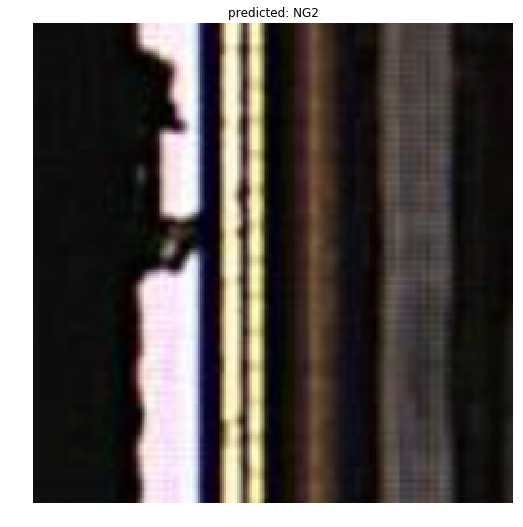

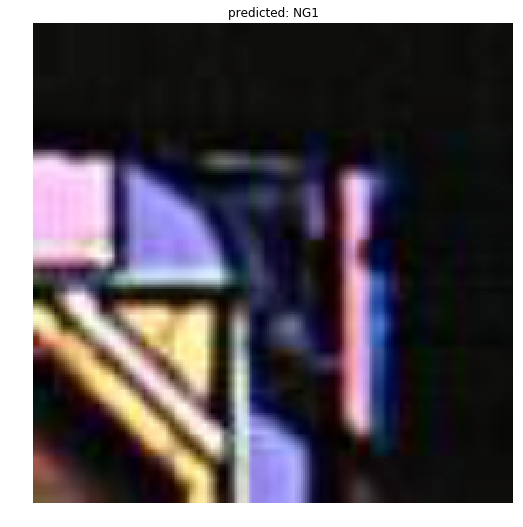

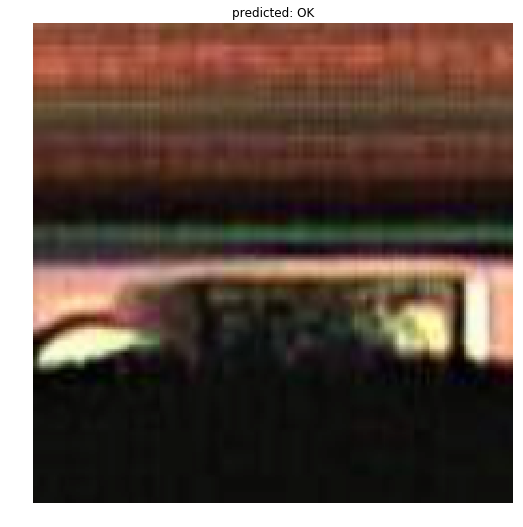

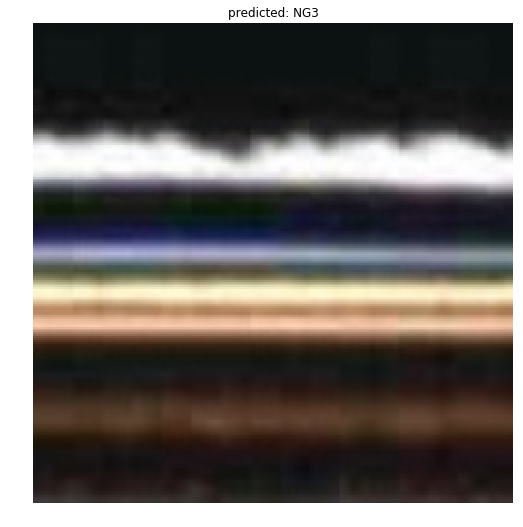

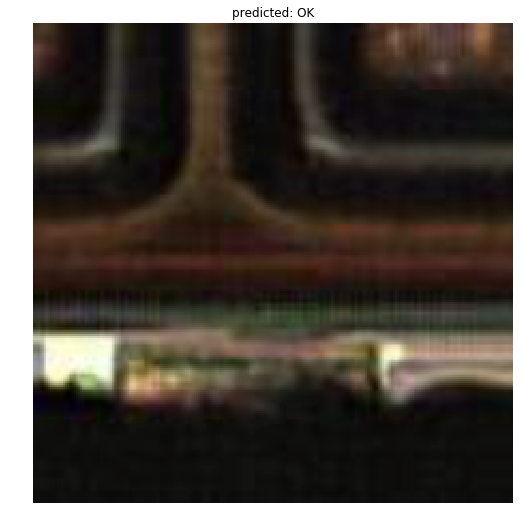

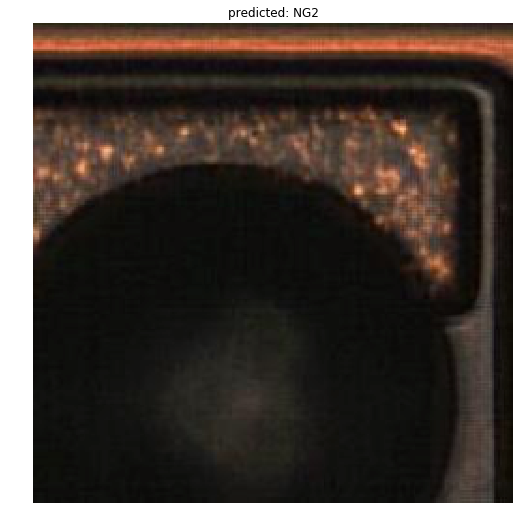

In [12]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [13]:
yt = torch.tensor(0)
yp = torch.tensor(0)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(tqdm(dataloaders['val'])):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        a = classes.cpu().flatten()
        b = preds.cpu().flatten()
        yt = torch.cat((yt.reshape(-1),a))
        yp = torch.cat((yp.reshape(-1),b))

yt = yt[1:]
yp = yp[1:]

100%|██████████| 54/54 [00:09<00:00,  5.71it/s]


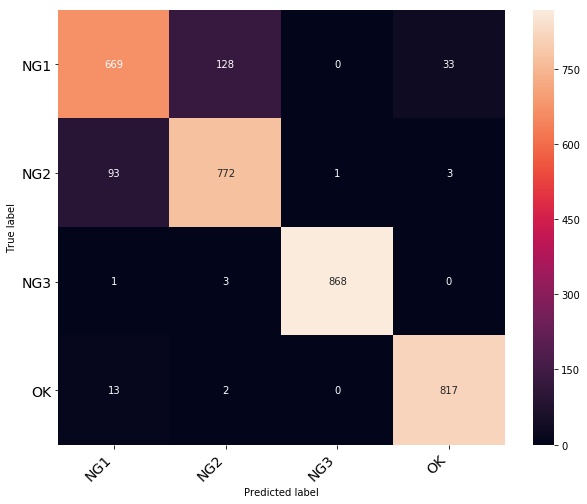

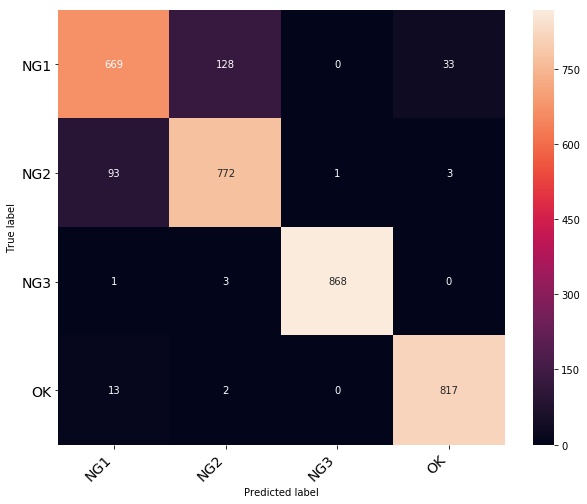

In [15]:
import pcm
from sklearn.metrics import confusion_matrix

pcm.print_confusion_matrix(confusion_matrix(yt, yp), class_names)

